In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pprint import pp
from que_onda import *
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import tensorflow as tf
import tensorflow_probability as tfp

np.set_printoptions(floatmode='unique')
dtype = tf.float32
n_levels = 10
wavelet_name = 'sym6'

wavelet = wavelets.by_name(wavelet_name, dtype)
filters = wavelets.dwt_filters(wavelet)


2025-04-18 17:40:40.472607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
files = os.walk('data')
# files = [
#          ('data/MedleyDB_V1', [], [
#                                    'AlexanderRoss_VelvetCurtain_MIX.mp3',
#                                    'CelestialShore_DieForUs_MIX.mp3',
#                                    'ClaraBerryAndWooldog_TheBadGuys_MIX.mp3',
#                                    'ClaraBerryAndWooldog_WaltzForMyVictims_MIX.mp3',
#                                    'Debussy_LenfantProdigue_MIX.mp3',
#                                    'EthanHein_BluesForNofi_MIX.mp3'
#                                    ]),
#          ('data/MedleyDB_V2', [], [
#                                    'Allegria_MendelssohnMovement1_MIX.mp3',
#                                    'BarefootSisters_RedJetta_MIX.mp3',
#                                    'CatMartino_IPromise_MIX.mp3',
#                                    'Cayetana_MissThing_MIX.mp3',
#                                    'DeclareAString_MendelssohnPianoTrio1Movement1_MIX.mp3',
#                                    'DeclareAString_MendelssohnPianoTrio1Movement2_MIX.mp3'
#                                   ])]

all_as = []
all_bs = []
all_cs = []
beat_lengths = []
min_beat_length = 9
max_beat_length = 63
max_lags = 188

# Logarithmic Decay with Shift: y = a * log(x + c) + b
def logarithmic_decay_shifted(x, a, b, c):
    return a * np.log(x + c) + b

for dirpath, dirnames, filenames in files:
    for filename in filenames:
        basename, _ = os.path.splitext(filename)
        print(basename)
        in_channels, samplerate = io.read_channels(os.path.join(dirpath, filename))
        in_levels = wavelets.wavedec_same(filters, n_levels, in_channels)
        in_frames = framing.levels_to_frames(in_levels)
        frame_level_energies = analysis.energy_by_frame_and_level(in_frames)
        frame_power = analysis.power_by_frame(frame_level_energies)

        x_data = np.arange(0, max_lags + 1)
        y_data = tfp.stats.auto_correlation(frame_power, max_lags=max_lags).numpy()

        short_x_data = x_data[min_beat_length:max_beat_length]
        short_y_data = y_data[min_beat_length:max_beat_length]

        # peaks, peak_properties = find_peaks(y_data, prominence=0.006, width=2)
        # plt.plot(x_data, y_data)
        # plt.plot(peaks + min_beat_length, y_data[peaks], 'x')
        # plt.savefig(f'temp/{basename}-lin.png')
        # plt.close()

        # shifted logarithmic decay model (Gemini)
        try:
            popt_shifted, pcov_shifted = curve_fit(logarithmic_decay_shifted, x_data, y_data, p0=(-0.08439892383834803, 0.7862034695405674, 0.07126941591678249))
        except Exception as e:
            print(f'!!! could not fit {basename}: {e}')
            continue
        a_opt_shifted, b_opt_shifted, c_opt_shifted = popt_shifted
        all_as.append(a_opt_shifted)
        all_bs.append(b_opt_shifted)
        all_cs.append(c_opt_shifted)
        print(f'y = {a_opt_shifted} * e^(x+{c_opt_shifted}) + {b_opt_shifted}')

        # Generate points for the fitted curves
        y_fit_shifted = logarithmic_decay_shifted(short_x_data, *popt_shifted)
        diff = short_y_data - y_fit_shifted

        raw_peaks, peak_properties = find_peaks(diff, prominence=0.008, width=2)
        peaks = raw_peaks + min_beat_length
        beat_lengths.extend(peaks)
        pp(peak_properties)

        # Plot the data and the fits
        plt.plot(short_x_data, y_fit_shifted)
        plt.plot(x_data, y_data)
        plt.plot(peaks, y_data[peaks], 'x')
        plt.savefig(f'temp/{basename}-log.png')
        plt.close()
        print()

        # beat_length = beats.find_length(frame_power)

        # x = np.arange(1, 202)
        # autocorrelation = tfp.stats.auto_correlation(frame_power, max_lags=200)
        # np_autocorrelation = autocorrelation.numpy()
        # beat_lengths.extend(peaks)

        # https://www.geeksforgeeks.org/how-to-do-exponential-and-logarithmic-curve-fitting-in-python/
        # logarithmic
        # log_x = np.log(x)
        # a, b = np.polyfit(log_x, np_autocorrelation, 1)
        # est = (a * log_x) + b
        # flattened = np_autocorrelation - est

        # for beat_length in peaks:
        #     n_frames = frame_power.shape[0]
        #     n_beats = n_frames // beat_length
        #     cut = frame_power[:n_beats * beat_length]
        #     intrabeat_power = tf.reshape(cut, [-1, beat_length])
        #     means = tf.reduce_mean(intrabeat_power, axis=0)
        #     plt.plot(means)
        #     plt.savefig(f'temp/{basename}-{beat_length}.png')
        #     plt.close()


JoelHelander_Definition_MIX
y = -0.09155340097199327 * e^(x+0.7807135715182394) + 0.9861285691717692
{'prominences': array([0.048433067897916904]),
 'left_bases': array([1]),
 'right_bases': array([38]),
 'widths': array([8.747475027333994]),
 'width_heights': array([0.0123223521825368]),
 'left_ips': array([18.412636891377023]),
 'right_ips': array([27.160111918711017])}

JoelHelander_ExcessiveResistancetoChange_MIX
y = -0.05279331945520439 * e^(x+0.11902379006256052) + 0.8974987921114663
{'prominences': array([0.08290862742446947]),
 'left_bases': array([11]),
 'right_bases': array([53]),
 'widths': array([11.126677725618965]),
 'width_heights': array([0.016316795317710575]),
 'left_ips': array([30.398097031663585]),
 'right_ips': array([41.52477475728255])}

TablaBreakbeatScience_CaptainSky_MIX
y = -0.054038127609327295 * e^(x+6.171820164632649e-06) + 0.351788184736372
{'prominences': array([0.10530062206617313 , 0.03390185371491311 , 0.40180847999507147 ,
       0.01585086679004027

/tmp/ipykernel_264/3797281971.py:30: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + c) + b


y = -0.06925942184306792 * e^(x+4.658400506203496e-05) + 0.30921841896544544
{'prominences': array([0.03719636718290956, 0.5432059227524875 ]),
 'left_bases': array([16, 16]),
 'right_bases': array([28, 53]),
 'widths': array([3.595496022359562 , 7.9107750350059405]),
 'width_heights': array([-0.06697773920686921,  0.16495880399355056]),
 'left_ips': array([23.65945025888553, 34.30267174772821]),
 'right_ips': array([27.254946281245093, 42.21344678273415 ])}

TablaBreakbeatScience_WhoIsIt_MIX
y = -0.07113778327804135 * e^(x+0.000738668553327869) + 0.4873768668105687
{'prominences': array([0.15326826431904728, 0.14532847222048378, 0.211900406334683  ]),
 'left_bases': array([11, 25, 11]),
 'right_bases': array([25, 38, 53]),
 'widths': array([4.783404173266419, 4.988483943258899, 5.973412124543636]),
 'width_heights': array([0.00814480015726049 , 0.008605108599673866, 0.017684952229650774]),
 'left_ips': array([16.432073716352136, 29.26575897530339 , 42.287293725645526]),
 'right_ips': 

In [3]:
(np.median(all_as), np.median(all_bs), np.median(all_cs))

(-0.08439892369537555, 0.786203468574468, 0.07126944629296454)

(array([ 0.,  4.,  7., 12.,  8.,  3.,  3.,  7.,  4.,  3.,  7., 13., 15.,
        20., 13.,  5.,  6., 15., 10.,  4.,  4.,  6.,  7.,  7., 11., 10.,
        10.,  6., 10.,  8.,  9., 11.,  4., 12.,  9., 13., 14., 28.,  9.,
         2.,  4.,  4., 12.,  6.,  9.,  8.,  7.,  8.,  3.,  7.,  3.,  1.,
         0.]),
 array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
        23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
        36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
        49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
        62., 63.]),
 <BarContainer object of 53 artists>)

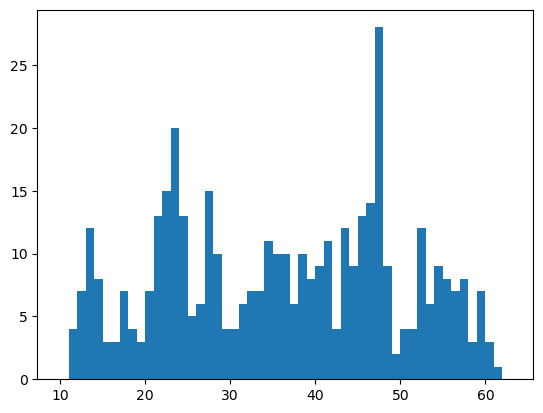

In [7]:
plt.hist(beat_lengths, bins=range(min(beat_lengths) - 1, max(beat_lengths) + 3, 1))

In [ ]:
# dataset, song, beat_length = 1, 'MusicDelta_Rock', 95                        # 49.5% (or 47, 20.5%)
# dataset, song, beat_length = 1, 'MusicDelta_Zeppelin', 94                      # 25.7% (or 23)
# dataset, song, beat_length = 1, 'MusicDelta_80sRock', 94                     # 61.5% (or 47, 64.6%)
# dataset, song, beat_length = 1, 'MusicDelta_Reggae', 94                      # 52.8% (or 47, 60.3%)
# dataset, song, beat_length = 1, 'MusicDelta_Hendrix',  94                    # 67.6%
# dataset, song, beat_length = 1, 'MusicDelta_InTheHalloftheMountainKing', 94  # 65.9%
# dataset, song, beat_length = 1, 'MusicDelta_Country2', 94                    # 71.7%
# dataset, song, beat_length = 1, 'MusicDelta_Shadows', 94                     # 26.0%
# dataset, song, beat_length = 1, 'MusicDelta_Vivaldi', 93                       # 27.2% (or 47, 35.8%)
# dataset, song, beat_length = 1, 'MusicDelta_Rockabilly', 94                  # 71.9%
# dataset, song, beat_length = 1, 'MusicDelta_Beethoven', 93                   # 24.4%
# dataset, song, beat_length = 1, 'MusicDelta_Beatles', 94                     # 44.3%
# dataset, song, beat_length = 2, 'Katzn_CharlieKnox', 42
# dataset, song, beat_length = 1, 'Creepoid_OldTree', 19
# dataset, song, beat_length = 1, 'TheSoSoGlos_Emergency', 29
# dataset, song, beat_length = 1, 'BigTroubles_Phantom', 21
# dataset, song, beat_length = 1, 'CelestialShore_DieForUs', 30
# dataset, song, beat_length = 1, 'TheDistricts_Vermont', 28

in_channels, samplerate = io.read_channels(f'data/MedleyDB_V{dataset}/{song}_MIX.mp3')


In [ ]:
name = 'sym6'
n_levels = 10

wavelet = wavelets.by_name(name, dtype)
filters = wavelets.dwt_filters(wavelet)
inverse_filters = wavelets.idwt_filters(wavelet)
in_levels = wavelets.wavedec_same(filters, n_levels, in_channels)
in_frames = framing.levels_to_frames(in_levels)
n_frames = in_frames[0].shape[0]


In [ ]:
frame_level_energies = analysis.energy_by_frame_and_level(in_frames)
frame_energies = analysis.energy_by_frame(frame_level_energies)
autocorrelation = tfp.stats.auto_correlation(frame_energies, max_lags=100)
np_autocorrelation = autocorrelation.numpy()

peaks, peak_properties = find_peaks(np_autocorrelation, height=0, prominence=0.05, width=1)
print(peaks)
first_peak = peaks[0]
print(f'first peak: {first_peak}')
print(f'properties: {peak_properties}')
print(f'At first peak: {np_autocorrelation[first_peak]}')
plt.plot(np_autocorrelation)
plt.plot(peaks, np_autocorrelation[peaks], 'x')


In [ ]:
offset = beats.find_offset(frame_energies, beat_length)
in_beats = beats.frames_to_beats(beat_length, in_frames, offset)
beat_level_energies = beats.energy_by_beat_and_level(in_beats)
beat_level_power = tf.sqrt(beat_level_energies)
distances = analysis.manhattan_distance_matrix(beat_level_power)
route = defrag.defrag(distances, time_limit=300)

In [ ]:
print(tf.reduce_max(beat_level_power, axis=0))

remixed = tf.gather(beat_level_power, route)
for l in tf.transpose(remixed):
    plt.plot(l)

In [ ]:
out_beats = beats.remix(in_beats, route)
out_frames = beats.beats_to_frames(out_beats)
out_levels = framing.frames_to_levels(out_frames)
out_channels = wavelets.waverec(inverse_filters, out_levels)
io.write_channels(f'temp/{song}-{name}-{beat_length}-sqrt.mp3', out_channels, samplerate)
